# Laborator 6 - Proiectarea Filtrelor

## Pachete utilizate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# Cresc DPI-ul ca să se vadă mai bine graficele
plt.rcParams['figure.dpi'] = 100

## 1) Răspunsul în frecvență al ferestrelor uzuale

Aceste ferestre au fost implementate în laboratorul anterior:

In [2]:
def construct_rectangular_window(width):
    "Construiește o fereastră dreptunghiulară de lățime dată"
    return np.ones(width)

def construct_hanning_window(width):
    "Construiește o fereastră Hanning de lățime dată"
    indices = np.arange(0, width)
    return 0.5 * (1 - np.cos(2 * np.pi * indices / width))

def construct_hamming_window(width):
    "Construiește o fereastră Hamming de lățime dată"
    indices = np.arange(width)
    return 0.54 - 0.46 * np.cos(2 * np.pi * indices / width)

def construct_blackman_window(width):
    "Construiește o fereastră Blackman de lățime dată"
    indices = np.arange(width)
    return (0.42 - 0.5 * np.cos(2 * np.pi * indices / width)
        + 0.08 * np.cos(4 * np.pi * indices / width))

def construct_flat_top_window(width):
    "Construiește o fereastră flat-top de lățime dată"
    indices = np.arange(width)
    return (0.22 - 0.42 * np.cos(2 * np.pi * indices / width)
        + 0.28 * np.cos(4 * np.pi * indices / width)
        - 0.08 * np.cos(6 * np.pi * indices / width)
        + 0.007 * np.cos(8 * np.pi * indices / width))

Definesc o funcție ajutătoare pentru afișarea răspunsului în frecvență a unei ferestre:

In [3]:
def plot_window_response(name, window):
    # Calculez răspunsul în frecvență
    w, h = scipy.signal.freqz(window)
    
    # Afișez rezultatul pe o scară logaritmică
    plt.suptitle(name)
    plt.xlabel('Frecvență (rad/sample)')
    plt.ylabel('Putere (dB)')
    plt.plot(w, 20 * np.log10(np.abs(h) + 1))
    plt.show()

In [4]:
window_width = 32

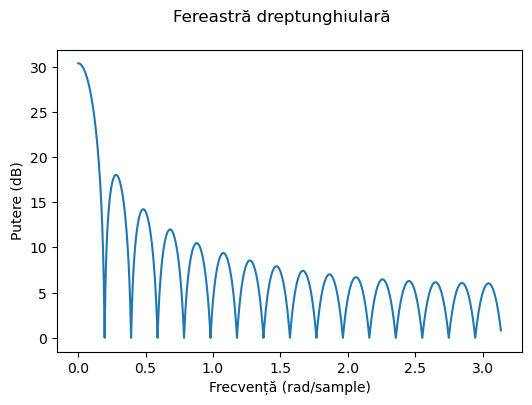

In [5]:
plot_window_response('Fereastră dreptunghiulară', construct_rectangular_window(window_width))

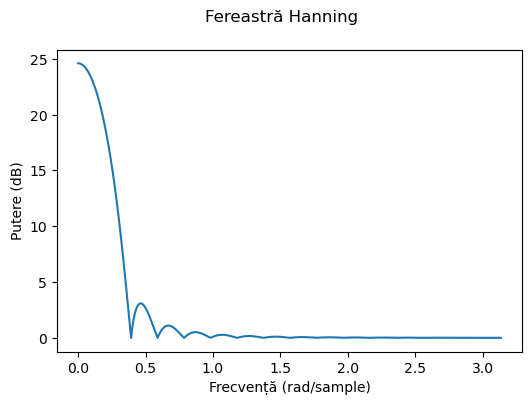

In [6]:
plot_window_response('Fereastră Hanning', construct_hanning_window(window_width))

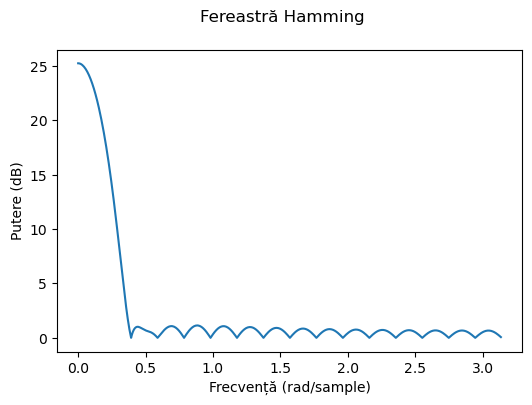

In [7]:
plot_window_response('Fereastră Hamming', construct_hamming_window(window_width))

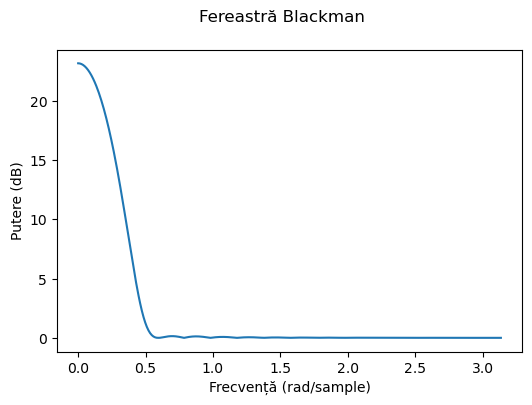

In [8]:
plot_window_response('Fereastră Blackman', construct_blackman_window(window_width))

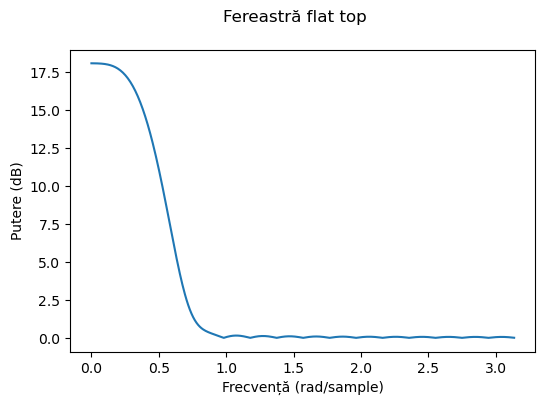

In [9]:
plot_window_response('Fereastră flat top', construct_flat_top_window(window_width))

## 2) Analiza datelor de trafic

### Citirea datelor

In [10]:
traffic_data = np.genfromtxt('trafic.csv')

### b) Alegerea frecvenței de tăiere

Datele au fost eșantionate la un interval de $1 \mathrm{h} = 3600 \mathrm{s}$, deci $f_s = 1/3600 \mathrm{Hz}$. Frecvența Nyquist este jumătate din frecvența de eșantionare.

In [11]:
sampling_period = 3600
sampling_rate = 1/sampling_period
nyquist_limit = sampling_rate/2

În trafic există anumite perioade mai aglomerate când oamenii merg spre / se întorc de la locul de muncă (dimineața și seara). Am estimat că o astfel de perioadă durează în jur de 4 ore, așa că aleg să filtrez componentele cu frecvență mai mare de 1/(4 ore).

Aleg frecvența de tăiere $\frac{1}{4} f_s$, adică $\frac{1}{2}$ din frecvența Nyquist.

In [12]:
low_pass_freq = sampling_rate / 4
print(f'Frecvența de tăiere: {low_pass_freq:.8f} Hz')

# Normalizez
low_pass_freq = low_pass_freq / nyquist_limit
print(f'Frecvența de tăiere:', low_pass_freq, '* frecvența Nyquist')

Frecvența de tăiere: 0.00006944 Hz
Frecvența de tăiere: 0.5 * frecvența Nyquist


### a) Spectrul semnalului

Aplicăm transformarea Fourier și afișăm componentele de frecvență:

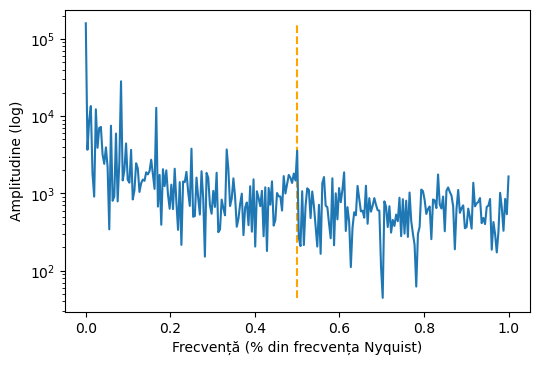

In [13]:
X = np.fft.rfft(traffic_data)
X_mag = np.abs(X)

normalized_freqs = np.linspace(0, 1, len(X))

# Afișez componentele de frecvență
plt.plot(normalized_freqs, X_mag)
plt.xlabel("Frecvență (% din frecvența Nyquist)")
plt.ylabel("Amplitudine (log)")
plt.ticklabel_format(scilimits=(0, 0))
plt.yscale('log')

# Afișez grafic frecvența de tăiere dorită
plt.vlines(low_pass_freq, ymin=X_mag.min(), ymax=X_mag.max(), linestyle='--', color='orange')

plt.show()

### c) Construirea filtrelor Butterworth și Chebyshev

Construiesc cele două filtre folosind parametrii inițiali dați în îndrumar:

In [14]:
# Ordinul filtrelor
order = 5
# Atenuarea oscilațiilor pentru filtrul Chebyshev
attenuation = 5

butter_b, butter_a = scipy.signal.butter(order, low_pass_freq)
cheby_b, cheby_a = scipy.signal.cheby1(order, attenuation, low_pass_freq)

### d) Afișarea răspunsului în frecvență a filtrelor

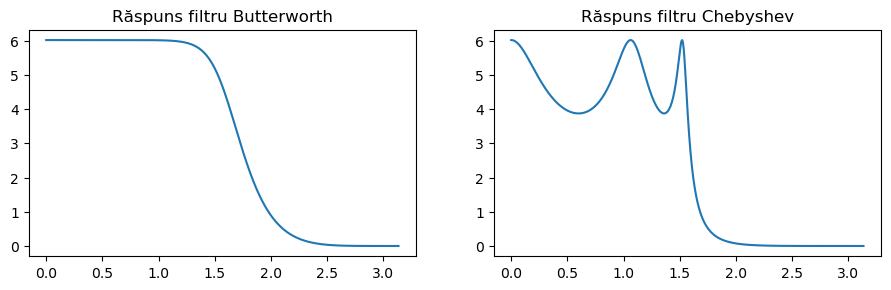

In [15]:
_, ax = plt.subplots(1, 2, figsize=(11, 3))

w, h = scipy.signal.freqz(butter_b, butter_a)
ax[0].plot(w, 20 * np.log10(np.abs(h) + 1))
ax[0].set_title('Răspuns filtru Butterworth')

w, h = scipy.signal.freqz(cheby_b, cheby_a)
ax[1].plot(w, 20 * np.log10(np.abs(h) + 1))
ax[1].set_title('Răspuns filtru Chebyshev')

plt.show()

### e) Filtrarea datelor cu filtrele construite

Aplic filtrele construite pe semnalul inițial:

In [16]:
butter_y = scipy.signal.filtfilt(butter_b, butter_a, traffic_data)
cheby_y = scipy.signal.filtfilt(cheby_b, cheby_a, traffic_data)

Rezultatul se vede mult mai bine dacă ne uităm la o fereastră de **3 zile** din semnal:

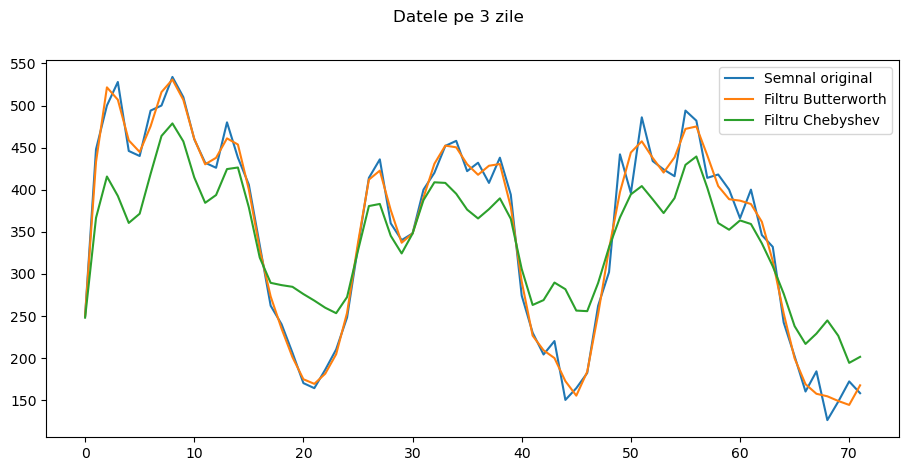

In [17]:
num_days = 3
limit = num_days * 24

plt.figure(figsize=(11, 5))

plt.suptitle(f'Datele pe {num_days} zile')
plt.plot(traffic_data[:limit], label='Semnal original')
plt.plot(butter_y[:limit], label='Filtru Butterworth')
plt.plot(cheby_y[:limit], label='Filtru Chebyshev')

plt.legend()
plt.show()

Filtrul care ne ajută mai mult să înțelegem datele este cel Chebyshev.

Pe lângă perioadele de la începutul și de la sfârșitul zilei, unde era de așteptat traficul intens, pare să mai fie o perioadă aglomerată și fix în mijlocul zilei.

### f) Valori optime ale parametrilor filtrului

După câteva încercări, am descoperit că obțin rezultate destul de bune dacă păstrez același ordin pentru filtru și cresc puțin atenuarea:

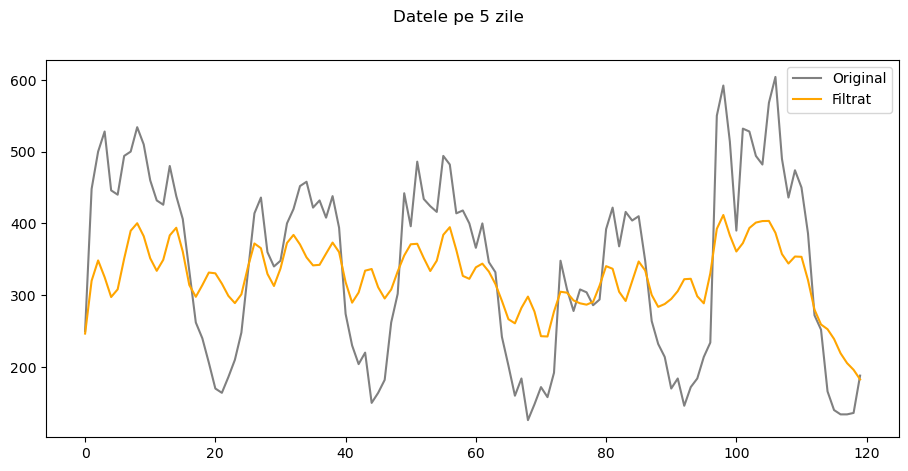

In [18]:
# Reconstruiesc filtrul
order = 5
attenuation = 10
b, a = scipy.signal.cheby1(order, attenuation, low_pass_freq)

# Filtrez datele
num_days = 5
limit = num_days * 24
x = traffic_data[:limit]
y = scipy.signal.filtfilt(b, a, x)

# Afișez rezultatul
plt.figure(figsize=(11, 5))
plt.suptitle(f'Datele pe {num_days} zile')
plt.plot(x, color='gray', label='Original')
plt.plot(y, color='orange', label='Filtrat')
plt.legend()
plt.show()